(content:f0estimation)=
# Fundamental frequency estimation

The [fundamental frequency (F0)](content:f0) is central
in describing speech signals whereby we need methods for estimating the
$F_0$ from speech signals. In speech analysis applications, it can be
informative to study the absolute value of the fundamental frequency as
such, but more commonly, extraction of the $F_0$ is usually a
pre-processing step. For example, in [recognition
tasks](content:recotasks), $F_0$ is often used as a
feature for machine learning methods. A voice activity detector could,
for instance, set a lower and higher threshold on the $F_0$, such that
sounds with an $F_0$ outside the valid range would be classified as
non-speech.

The fundamental frequency is visible in multiple different domains:

-   In an acoustic time signal, the $F_0$ is visible as a repetition after
    every $T$ samples.
-   In the [autocovariance or
    -correlation](content:xcorr), the $F_0$ is visible
    as a peak at lag $T$ as well as its integer multiples $kT$.
-   In the magnitude, power or log-magnitude
    [spectrum](stft), the $F_0$ is visible as a peak at
    the frequency $F_0=F_{s}/T$, as well as its integer
    multiples, where $F_{s}$ is the sampling frequency.
-   In the [cepstrum](content:mfcc), the $F_0$ is visible as a peak at
    quefrency $T$ as well as its integer multiples $kT$.

Consequently, we can use any of these domains to estimate the
fundamental frequency $F_0$. A typical approach applicable in all domains
except the time domain is peak-picking. The fundamental frequency
corresponds to a peak in each domain, such that we can determine the $F_0$
by finding the highest peak. For better robustness to spurious peaks and
computational efficiency, we naturally limit our search to the range
of valid $F_0$'s, such as  $ 80\leq F_0\leq 450. $  

The harmonic structure, however, poses a problem for peak-picking. Peaks
appear at integer multiples of either $F_0$ or lag T, such that sometimes,
by coincidence or due to estimation errors, the harmonic peaks can be
higher than the primary peak. Such estimation errors are known
as *octave errors* because the error in $F_0$ corresponds to the musical
interval of an octave. A typical post-processing step is, therefore, to
check for octave jumps. We can check whether $F_0/2$ or $F_0/3$ 
correspond to a sensible $F_0$. Alternatively, we can check whether the
previous analysis frame had an $F_0$, an octave, or two octaves off.
Depending on the application, we can then fix errors or label problematic
zones for later use.

Another problem with peak picking is that peak locations might not align
with the samples. For example, in the autocorrelation domain, the actual
length of the period could be 100.3 samples. However, the peak in the
autocorrelation would then appear at lag 100. One approach would then be
to use quadratic interpolation between samples near a peak
and use the location of the maximum of the interpolated peak to estimate the peak location. Interpolation makes the estimate less
sensitive to noise. For example, background noise could 
peak at lag 102, so the desired maximum of 100 is lower than the peak
at 102. By using data from more samples, as in the interpolation
approach, we can, therefore, reduce the likelihood that a single corrupted
data point would cause an error.

An alternative approach to peak-picking is to use all distinctive peaks
to estimate the $F_0$ jointly. That is, if you find $N$ peaks at
frequencies $p_{k}$, which approximately correspond to harmonic
peaks $kF0$, then you can approximate $ F_0 \approx \frac1N
\sum_{k=1}^N p_k/k. $ Another alternative is to calculate the
distance between consecutive peaks and estimate $ F_0 \approx
\frac1{N-1} \sum_{k=1}^{N-1} (p_{k+1}-p_k). $ We can also combine
these methods as we like.

A further potential improvement is to compare subsequent frames. The pitch in speech is fairly continuous over time, and subsequent frames should, therefore, have similar F0s. This can be used to reduce the danger of octave jumps.

In many other applications, we use discrete Fourier transform (DFT) or
cosine transforms (DCT) to resolve frequency components. It would, therefore, be tempting to apply the same approach here. In such a
domain, we would also already have a joint estimate which does not rely on single data points. However, note that the spectrum is already the DFT of the time signal, and the cepstrum is the DCT or DFT of the log-spectrum. Additional transforms, therefore, usually do not resolve the ambiguity between harmonics. 

A classic algorithm for fundamental frequency estimation is YIN {cite}`deCheveigne2002yin`, which has been later improved with a probabilistic version pYIN {cite}`mauch2014pyin`. YIN is based on peak picking in the autocorrelation domain while emphasizing continuity over time.

## Examples

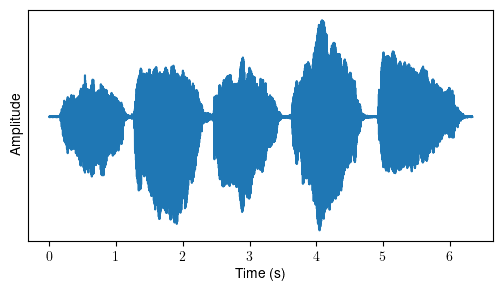

In [13]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np
import IPython

filename = 'f0sample.wav'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

# read from storage
fs, data = wavfile.read(filename)
data = data[:,0]
time = np.arange(len(data))/fs

IPython.display.display(IPython.display.Audio(data,rate=fs))
plt.figure(figsize=(6,3))
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.yticks([])
plt.show()

Excerpts of each tone (columns) with a square (upper row) and a Hann window (lower row).

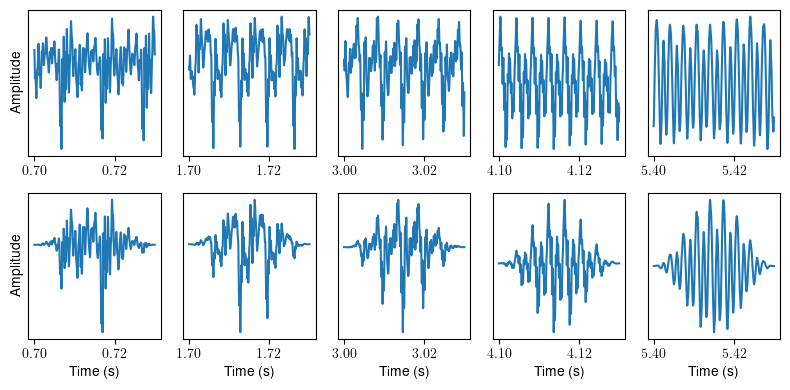

In [25]:
window_length_ms = 30

window_length = int(window_length_ms*fs/1000)
window_time = np.arange(window_length)
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2


time_sec_list = [0.7, 1.7, 3, 4.1, 5.4]
plt.figure(figsize=(8,4))

for k in range(5):
    time_ix = int(time_sec_list[k]*fs) + window_time
    plt.subplot(251+k)
    plt.plot(time_ix/fs, data[time_ix])
    if k==0: plt.ylabel('Amplitude')
    plt.yticks([])
    plt.subplot(2,5,6+k)
    plt.plot(time_ix/fs, data[time_ix]*windowing_function)
    plt.xlabel('Time (s)')
    if k==0: plt.ylabel('Amplitude')
    plt.yticks([])

plt.tight_layout()

The (loosly) periodic structure is visible for each tone as a repeated waveform. Left to right, the pitch increases and the period length becomes shorter such that more periods fit the 30ms analysis window. We also note that for the lowest tone, the periods are nicely visible with the square window (upper row), but less so with the Hann window.

To estimate the fundamental frequency, recall that for a zero-mean signal $x_k$ with a period length $L$, we should have $x_k \approx x_{k-L}$ or equivalently, zero expectation $E\left[\left(x_k - x_{k-L}\right)^2\right]=0.$ For a sample segment of length $N$, the expectation has 

$$
0=E\left[\left(x_k - x_{k-L}\right)^2\right] \approx \frac1N \sum_{k=0}^{N-1} \left( x_k - x_{k-L} \right)^2 = \frac1N\left\|{\mathbf x}_k-{\mathbf x}_{k-L}\right\|^2.
$$

Here ${\mathbf x}_k$ is a vector containing the samples of $x_k$ to $x_{k+N}$. 

To find the fundamental frequency, we can then find that $L$ where the above norm is closest to zero. 

$$
\begin{split}
\hat L &
:= \arg\min_L \frac1N\left\|{\mathbf x}_k-{\mathbf x}_{k-L}\right\|^2 
= \arg\min_L \left[\left\|{\mathbf x}_k\right\|^2-2{\mathbf x}_k^T{\mathbf x}_{k-L}^T + \left\|{\mathbf x}_{k-L}\right\|^2 \right]
\\&
= \arg\max_L {\mathbf x}_k^T{\mathbf x}_{k-L}^T ,
\end{split}
$$

where constants that do not depend on $L$ were omitted, and the minimum was replaced by the maximum by changing the sign. We thus obtained the maximization of the correlation between the signal and its delayed version. Note that this makes this approach equivalent with estimating the maximum of the [autocorrelation](content:xcorr) function.

In [71]:
f0_range_Hz = np.array([80, 450])
f0_range = np.round(fs/np.flipud(f0_range_Hz)).astype(int)

print(f"Frequency range {f0_range_Hz[0]} to {f0_range_Hz[1]} Hz. "
      f"Lag range {(1000/f0_range_Hz[1]):2.2f} to {(1000/f0_range_Hz[0]):2.2f} ms or\n{f0_range[0]} to {f0_range[1]} samples with the sampling rate {fs/1000} kHz.")

correlation = np.zeros([5,window_length-1])

for k in range(5):
    time_ix = int(time_sec_list[k]*fs) + window_time
    xwin = data[time_ix]*windowing_function    
    for L in range(window_length-1):
        x_k = xwin[:window_length-L]
        x_kL = xwin[L:window_length]
        correlation[k,L] = np.sum(x_k*x_kL)/(window_length-L)

max_lag = np.argmax(correlation[:,f0_range[0]:f0_range[1]],axis=1)+f0_range[0]
        

Frequency range 80 to 450 Hz. Lag range 2.22 to 12.50 ms or
98 to 551 samples with the sampling rate 44.1 kHz.


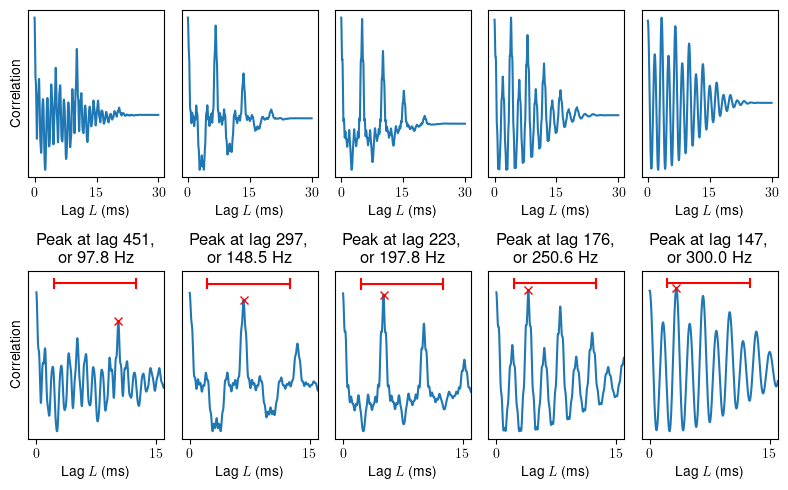

In [88]:
plt.figure(figsize=(8,5))
for k in range(5):
    plt.subplot(2,5,1+k)
    plt.plot(1000*np.arange(window_length-1)/fs, correlation[k,:])
    plt.xlabel('Lag $L$ (ms)')
    if k==0: plt.ylabel('Correlation')
    plt.yticks([])    
    plt.xticks([0, 15,30]) 

    plt.subplot(2,5,6+k)
    plt.plot(1000*np.arange(window_length-1)/fs, correlation[k,:])
    plt.plot(1000*np.array([f0_range[0], f0_range[0], f0_range[0], f0_range[1], f0_range[1], f0_range[1]])/fs,
             correlation[k,0]*np.array([1.15, 1.05, 1.1, 1.1, 1.05, 1.15]),color='red')

    plt.plot(1000*max_lag[k]/fs, correlation[k,max_lag[k]], 'rx')
    plt.title(f"Peak at lag {max_lag[k]}, \nor {fs/max_lag[k]:2.1f} Hz")
    plt.xlabel('Lag $L$ (ms)')
    if k==0: plt.ylabel('Correlation')
    plt.yticks([])
    plt.xticks([0, 15]) 
    plt.xlim([-1, 16])
    

plt.tight_layout()
plt.show()

The upper row shows the whole correlation, while the lower row zooms near the valid range of lags (indicated by the red lines). Red crosses show the maximum peak.

With this easy sound example, the maxima are easy to discern. However, with both the lowest (leftmost) and highest (rightmost) pitches, other peaks are very close in magnitude to the true pitch. As this was an easy signal, it is thus not difficult to imagine more challenging sounds where peak picking would land at the incorrect peak.

We can repeat the experiment using the [power spectrum](stft) (squared absolute spectrum).

In [141]:
fft_length = window_length
spectrum_length = (fft_length//2)+1
f0_range_fft_indices = np.round(f0_range_Hz*fft_length/fs).astype(int)

power_spectrum = np.zeros([5,spectrum_length])
for k in range(5):
    time_ix = int(time_sec_list[k]*fs) + window_time
    xwin = data[time_ix]*windowing_function    
    power_spectrum[k,:] = np.abs(scipy.fft.rfft(xwin,n=fft_length))**2

max_frequency_index = np.argmax(
    power_spectrum[:,f0_range_fft_indices[0]:f0_range_fft_indices[1]],
    axis=1) +f0_range_fft_indices[0]
max_frequency = max_frequency_index*fs/fft_length        

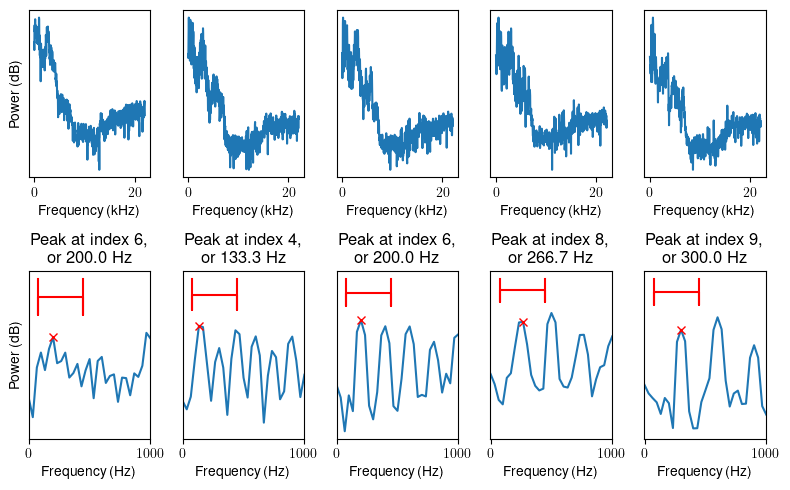

In [142]:
fft_ix = np.linspace(0,fs/2,spectrum_length)
plot_range_Hz = np.arange(0, 1200)
plot_range = np.round(plot_range_Hz*fft_length/fs).astype(int)

plt.figure(figsize=(8,5))
for k in range(5):
    plt.subplot(2,5,1+k)
    plt.plot(fft_ix/1000, 10*np.log10(power_spectrum[k,:]))
    plt.xlabel('Frequency (kHz)')
    if k==0: plt.ylabel('Power (dB)')
    plt.yticks([])    

    plt.subplot(2,5,6+k)
    plt.plot(fft_ix[plot_range], 
             10*np.log10(power_spectrum[k,plot_range]))
    plt.plot(np.array([f0_range_Hz[0], 
                            f0_range_Hz[0], 
                            f0_range_Hz[0], 
                            f0_range_Hz[1], 
                            f0_range_Hz[1], 
                            f0_range_Hz[1]]),
             10*np.log10(np.max(power_spectrum[k,:]))*np.array([1.15, 1.05, 1.1, 1.1, 1.05, 1.15]),color='red')

    plt.plot(max_frequency[k], 
             10*np.log10(power_spectrum[k,max_frequency_index[k]]), 
             'rx')
    plt.title(f"Peak at index {max_frequency_index[k]}, \nor {max_frequency[k]:2.1f} Hz")
    plt.xlabel('Frequency (Hz)')
    if k==0: plt.ylabel('Power (dB)')
    plt.yticks([])
    plt.xlim([-1, 1000])
    

plt.tight_layout()
plt.show()

Observe that the y-axis is now expressed in decibels. The upper row has the complete spectrum of each tone, while the lower row zooms in on the frequency range where the fundamental is visible. 

We immediately observe that for the lowest (leftmost) tone, the pitch is incorrectly estimated as it picks up the second peak of the harmonic structure. In fact, for the two highest pitches, the second harmonic peak is higher than the first, but it is not incorrectly picked up only because it is outside the defined frequency analysis range. Furthermore, the accuracy of estimated frequencies is low because that the density of frequencies is not sufficient. The accuracy can however be improved by oversampling the spectrum, that is, by extending the analysis window by zeros before the Fourier transform.

In other words, let us extend the vector with zeros to a length equal to the sampling rate (44100).

In [143]:
fft_length = fs
spectrum_length = (fft_length//2)+1
f0_range_fft_indices = np.round(f0_range_Hz*fft_length/fs).astype(int)

power_spectrum = np.zeros([5,spectrum_length])
for k in range(5):
    time_ix = int(time_sec_list[k]*fs) + window_time
    xwin = data[time_ix]*windowing_function    
    power_spectrum[k,:] = np.abs(scipy.fft.rfft(xwin,n=fft_length))**2

max_frequency_index = np.argmax(
    power_spectrum[:,f0_range_fft_indices[0]:f0_range_fft_indices[1]],
    axis=1) +f0_range_fft_indices[0]
max_frequency = max_frequency_index*fs/fft_length        

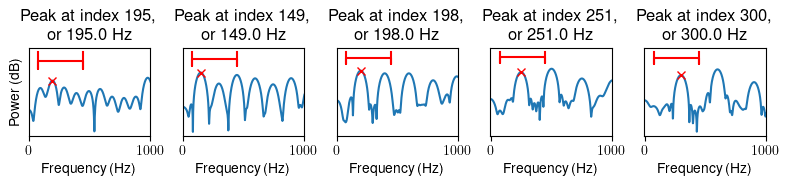

In [145]:
fft_ix = np.linspace(0,fs/2,spectrum_length)
plot_range_Hz = np.arange(0, 1200)
plot_range = np.round(plot_range_Hz*fft_length/fs).astype(int)

plt.figure(figsize=(8,3))
for k in range(5):
    plt.subplot(2,5,1+k)
    plt.plot(fft_ix[plot_range], 
             10*np.log10(power_spectrum[k,plot_range]))
    plt.plot(np.array([f0_range_Hz[0], 
                            f0_range_Hz[0], 
                            f0_range_Hz[0], 
                            f0_range_Hz[1], 
                            f0_range_Hz[1], 
                            f0_range_Hz[1]]),
             10*np.log10(np.max(power_spectrum[k,:]))*np.array([1.15, 1.05, 1.1, 1.1, 1.05, 1.15]),color='red')

    plt.plot(max_frequency[k], 
             10*np.log10(power_spectrum[k,max_frequency_index[k]]), 
             'rx')
    plt.title(f"Peak at index {max_frequency_index[k]}, \nor {max_frequency[k]:2.1f} Hz")
    plt.xlabel('Frequency (Hz)')
    if k==0: plt.ylabel('Power (dB)')
    plt.yticks([])
    plt.xlim([-1, 1000])
    

plt.tight_layout()
plt.show()

It is now much easier to determine the exact location of each peak and thus the frequency estimates are also more accurate. However, this did not solve the octave jump in the lowest (leftmost) tone, where the second harmonic is still larger than the first, true peak.

The third main feature often used for F0 estimation is the [cepstrum](content:melcepstrum).

In [ ]:
fft_length = window_length
spectrum_length = (fft_length//2)+1
f0_range_fft_indices = np.round(f0_range_Hz*fft_length/fs).astype(int)

power_spectrum = np.zeros([5,spectrum_length])
for k in range(5):
    time_ix = int(time_sec_list[k]*fs) + window_time
    xwin = data[time_ix]*windowing_function    
    power_spectrum[k,:] = np.abs(scipy.fft.rfft(xwin,n=fft_length))**2

In [ ]:
cepstrum = scipy.fft.irfft(10*np.log10(power_spectrum),axis=1)

max_cepstral_peak = np.argmax(cepstrum[:,f0_range[0]:f0_range[1]],axis=1)+f0_range[0]

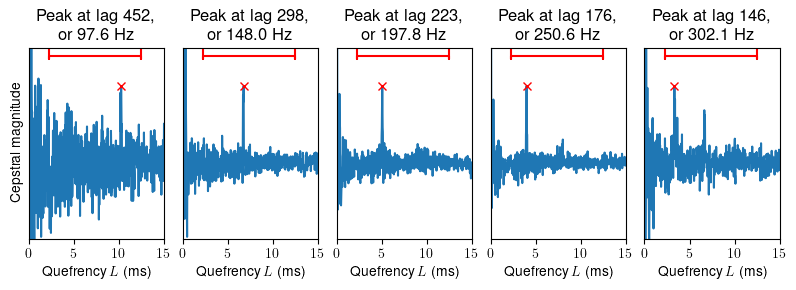

In [170]:
plt.figure(figsize=(8,3))
for k in range(5):
    plt.subplot(1,5,1+k)
    # plt.plot(1000*np.arange(window_length-1)/fs, cepstrum[k,:])
    # plt.xlabel('Quefrency $L$ (ms)')
    # if k==0: plt.ylabel('Cepstral magnitude')
    # plt.yticks([])    
    # plt.xlim([0, 15]) 
    # plt.ylim(cepstrum[k,max_cepstral_peak[k]]*np.array([-1,1.5]))

    # plt.subplot(2,5,6+k)
    plt.plot(1000*np.arange(window_length-1)/fs, cepstrum[k,:])
    plt.plot(1000*np.array([f0_range[0], f0_range[0], f0_range[0], f0_range[1], f0_range[1], f0_range[1]])/fs,
             cepstrum[k,max_cepstral_peak[k]]*np.array([1.55, 1.35, 1.4, 1.4, 1.35, 1.55]),color='red')

    plt.plot(1000*max_cepstral_peak[k]/fs, cepstrum[k,max_cepstral_peak[k]], 'rx')
    plt.title(f"Peak at lag {max_cepstral_peak[k]}, \nor {fs/max_cepstral_peak[k]:2.1f} Hz")
    plt.xlabel('Quefrency $L$ (ms)')
    if k==0: plt.ylabel('Cepstral magnitude')
    plt.yticks([])    
    plt.xlim([0, 15]) 
    plt.ylim(cepstrum[k,max_cepstral_peak[k]]*np.array([-1,1.5]))
    

plt.tight_layout()
plt.show()

The peaks are much more pronounced here in the cepstrum in the sense that they are sharp and easily distinguishable from the noise. Still, the same danger of octave jumps persists in the lowest and highest tones, as there are other high peaks in the search range (red lines). However, since the peaks are now narrow, we cannot easily interpolate between points to find a more accurate location of the peak.